<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#find-products-for-simulation" data-toc-modified-id="find-products-for-simulation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>find products for simulation</a></span></li><li><span><a href="#explore-products-for-simulation" data-toc-modified-id="explore-products-for-simulation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>explore products for simulation</a></span></li><li><span><a href="#conversion-rates" data-toc-modified-id="conversion-rates-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>conversion rates</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## Data

m5 dataset https://www.kaggle.com/competitions/m5-forecasting-accuracy/data

In [3]:
import os

In [4]:
base_dir = '../data/m5/'

In [5]:
sales_path = os.path.join(base_dir, 'sales_train_validation.csv')
sales = pd.read_csv(sales_path)

In [8]:
prices_path = os.path.join(base_dir, 'sell_prices.csv')
prices = pd.read_csv(prices_path)

In [106]:
calendar_path = os.path.join(base_dir, 'calendar.csv')
calendar = pd.read_csv(calendar_path)

In [7]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [10]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


## EDA

### find products for simulation

I will firstly find the products which can be used for simulations

those products should have
- high demand
- big number of price changes

calculate the number of unique prices for each product

In [44]:
product_nprices = prices.groupby(['store_id', 'item_id']).sell_price.nunique().sort_values(ascending=False)
product_nprices = product_nprices.reset_index()
product_nprices = product_nprices.rename(columns={'sell_price': 'n_prices'})

In [45]:
product_nprices.head(10)

,store_id,item_id,n_prices
0,TX_1,FOODS_1_095,21
1,TX_3,FOODS_1_095,21
2,WI_1,FOODS_1_129,20
3,CA_4,FOODS_1_095,18
4,TX_2,FOODS_1_095,18
5,WI_3,FOODS_1_129,18
6,CA_1,FOODS_1_095,18
7,WI_2,FOODS_1_129,18
8,CA_2,FOODS_1_095,18
9,WI_3,FOODS_1_096,17


seems good

find the most popular products (store_id, item_id) by the number of sold items

In [35]:
d_cols = [c for c in sales.columns if c.startswith('d_')]

In [36]:
sales['sold_sum'] = sales[d_cols].sum(axis=1)

In [50]:
product_sales = sales.sort_values('sold_sum', ascending=False).drop(columns=d_cols)

In [57]:
products = product_sales.merge(product_nprices, on=['store_id', 'item_id'])
products['cum_sold_sum_pct'] = products['sold_sum'].cumsum() / products['sold_sum'].sum()

In [58]:
products.head(20)

,id,item_id,dept_id,cat_id,store_id,state_id,sold_sum,n_prices,cum_sold_sum_pct
0,FOODS_3_090_CA_3_validation,FOODS_3_090,FOODS_3,FOODS,CA_3,CA,250502,8,0.003813
1,FOODS_3_586_TX_2_validation,FOODS_3_586,FOODS_3,FOODS,TX_2,TX,192835,3,0.006748
2,FOODS_3_586_TX_3_validation,FOODS_3_586,FOODS_3,FOODS,TX_3,TX,150122,3,0.009033
3,FOODS_3_586_CA_3_validation,FOODS_3_586,FOODS_3,FOODS,CA_3,CA,134386,3,0.011079
4,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,127203,8,0.013015
5,FOODS_3_090_WI_3_validation,FOODS_3_090,FOODS_3,FOODS,WI_3,WI,121434,8,0.014864
6,FOODS_3_090_TX_2_validation,FOODS_3_090,FOODS_3,FOODS,TX_2,TX,119496,8,0.016683
7,FOODS_3_090_TX_3_validation,FOODS_3_090,FOODS_3,FOODS,TX_3,TX,114854,8,0.018431
8,FOODS_3_252_TX_2_validation,FOODS_3_252,FOODS_3,FOODS,TX_2,TX,114153,2,0.020169
9,FOODS_3_586_TX_1_validation,FOODS_3_586,FOODS_3,FOODS,TX_1,TX,112454,3,0.021880


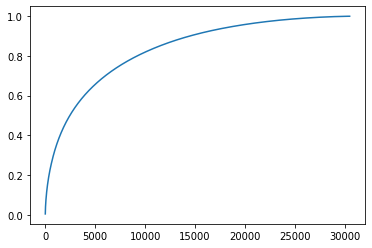

In [60]:
plt.plot(products['cum_sold_sum_pct']);

looks good, can take some produtcs with 8 price changes for experiments

In [62]:
mask = (
    (products['cum_sold_sum_pct'] < 0.6) &
    (products['n_prices'] >= 8)
)
selected_products = products[mask].copy().reset_index(drop=True)

In [66]:
selected_products.shape

(164, 9)

164 products

That is a big number of products, I will look more deeply into them

In [74]:
cols = ['store_id', 'item_id']
selected_sales = sales.merge(selected_products[cols], on=cols)

### explore products for simulation

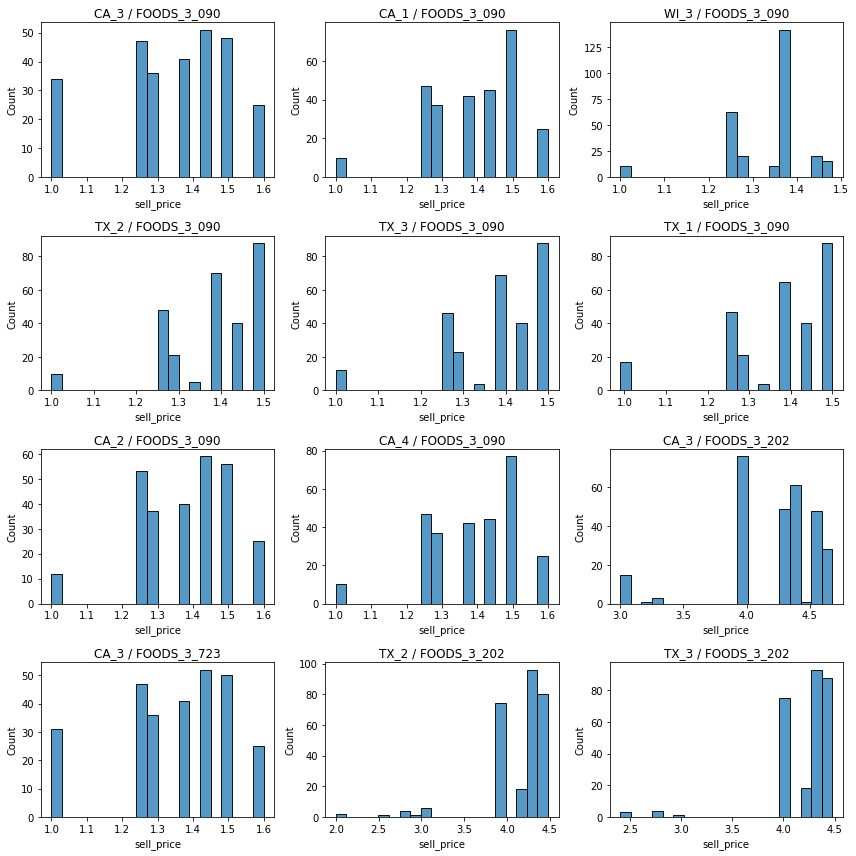

In [84]:
fig,axs = plt.subplots(figsize=(12, 12))

for i, (_, r) in enumerate(selected_products.iterrows()):
    ax = plt.subplot(4, 3, i+1)
    mask = (
        (prices['store_id'] == r['store_id']) &
        (prices['item_id'] == r['item_id'])
    )
    df = prices[mask]
    sns.histplot(x='sell_price', data=df, bins=20,ax=ax)
    plt.title(f"{r['store_id']} / {r['item_id']}");
    if i == 11:
        break
    
fig.tight_layout()

FOODS_3_090 is a really good product, it had many prices tried
for different stores

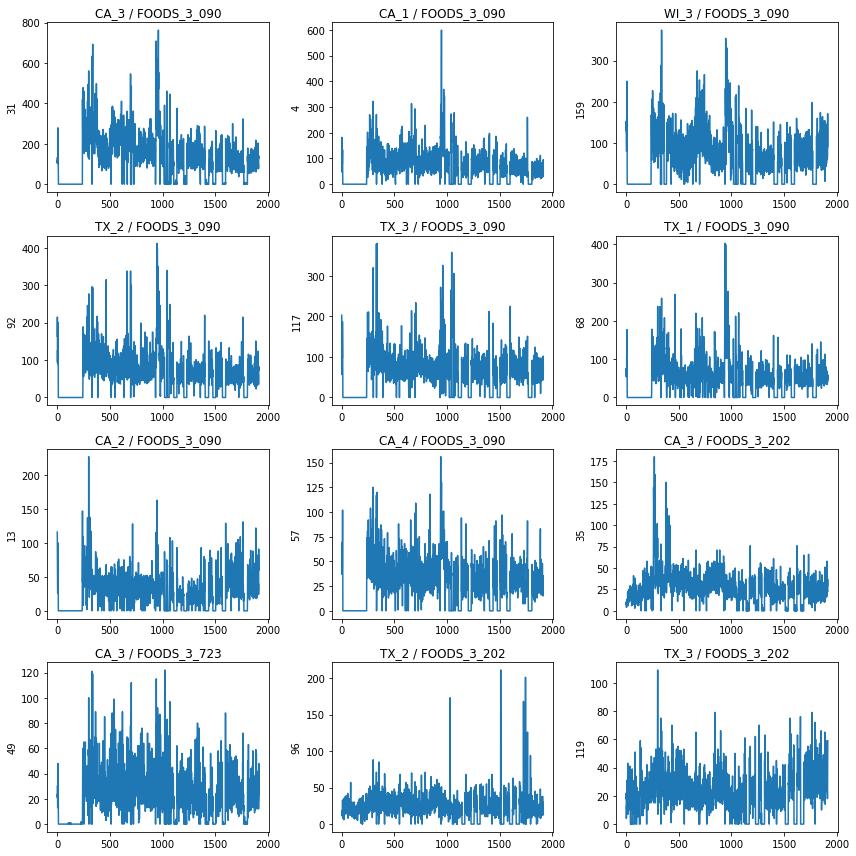

In [97]:
fig,axs = plt.subplots(figsize=(12, 12))

for i, (_, r) in enumerate(selected_products.iterrows()):
    ax = plt.subplot(4, 3, i+1)
    mask = (
        (selected_sales['store_id'] == r['store_id']) &
        (selected_sales['item_id'] == r['item_id'])
    )
    df = selected_sales[mask]
    sns.lineplot(x=range(1, len(d_cols)+1), y=df[d_cols].T.iloc[:, 0], ax=ax)
    plt.title(f"{r['store_id']} / {r['item_id']}");
    if i == 11:
        break
    
fig.tight_layout()

sometimes have huge spikes - maybe american events

have also lots of missing values for FOODS_3_090 in all stores in the beginning - those types of data errors should be processed (in  this case simply dropped)

also sometimes have out of stock moments

other than that, cannot see the general trend for the product, quite stable demand

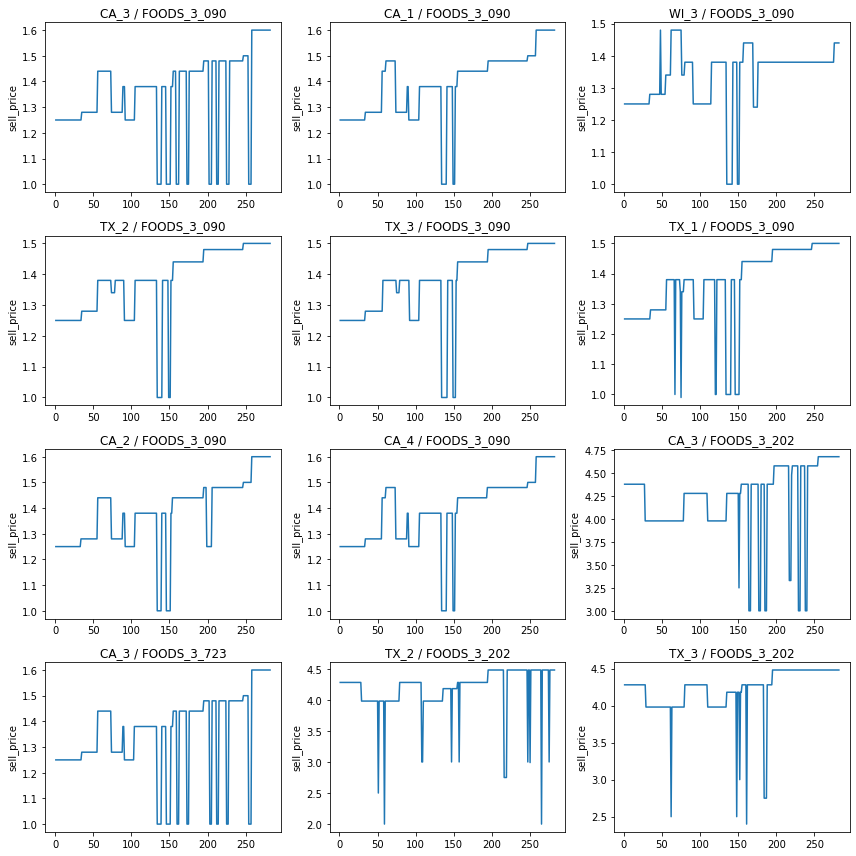

In [104]:
fig,axs = plt.subplots(figsize=(12, 12))

for i, (_, r) in enumerate(selected_products.iterrows()):
    ax = plt.subplot(4, 3, i+1)
    mask = (
        (prices['store_id'] == r['store_id']) &
        (prices['item_id'] == r['item_id'])
    )
    df = prices[mask]
    sns.lineplot(x=range(1, df.shape[0]+1), y=df['sell_price'], ax=ax)
    plt.title(f"{r['store_id']} / {r['item_id']}");
    if i == 11:
        break
    
fig.tight_layout()

observations:
- slight inflation is possible

> merge prices and sales

In [110]:
cols = ['date', 'wm_yr_wk', 'd']
prices_to_merge = prices.merge(calendar[cols], on='wm_yr_wk')

In [116]:
prices_to_merge.head()

,store_id,item_id,wm_yr_wk,sell_price,date,d
0,CA_1,HOBBIES_1_001,11325,9.58,2013-07-13,d_897
1,CA_1,HOBBIES_1_001,11325,9.58,2013-07-14,d_898
2,CA_1,HOBBIES_1_001,11325,9.58,2013-07-15,d_899
3,CA_1,HOBBIES_1_001,11325,9.58,2013-07-16,d_900
4,CA_1,HOBBIES_1_001,11325,9.58,2013-07-17,d_901


In [203]:
index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
long_sales = pd.melt(
    selected_sales[index_columns+d_cols], 
    id_vars = index_columns, 
    var_name = 'd', 
    value_name = 'quantity')

In [204]:
cols = ['store_id', 'item_id', 'd']
long_sales = long_sales.merge(prices_to_merge, on=cols, how='left')

In [205]:
# some products started selling after d_1 (i.e the starting day of the dataset)
long_sales = long_sales.dropna().reset_index(drop=True)

In [130]:
long_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,quantity,wm_yr_wk,sell_price,date
0,FOODS_2_212_CA_1_validation,FOODS_2_212,FOODS_2,FOODS,CA_1,CA,d_1,11,11101.0,4.18,2011-01-29
1,FOODS_3_090_CA_1_validation,FOODS_3_090,FOODS_3,FOODS,CA_1,CA,d_1,107,11101.0,1.25,2011-01-29
2,FOODS_3_274_CA_1_validation,FOODS_3_274,FOODS_3,FOODS,CA_1,CA,d_1,16,11101.0,1.25,2011-01-29
3,FOODS_3_491_CA_1_validation,FOODS_3_491,FOODS_3,FOODS,CA_1,CA,d_1,35,11101.0,1.25,2011-01-29
4,FOODS_3_723_CA_1_validation,FOODS_3_723,FOODS_3,FOODS,CA_1,CA,d_1,17,11101.0,1.25,2011-01-29


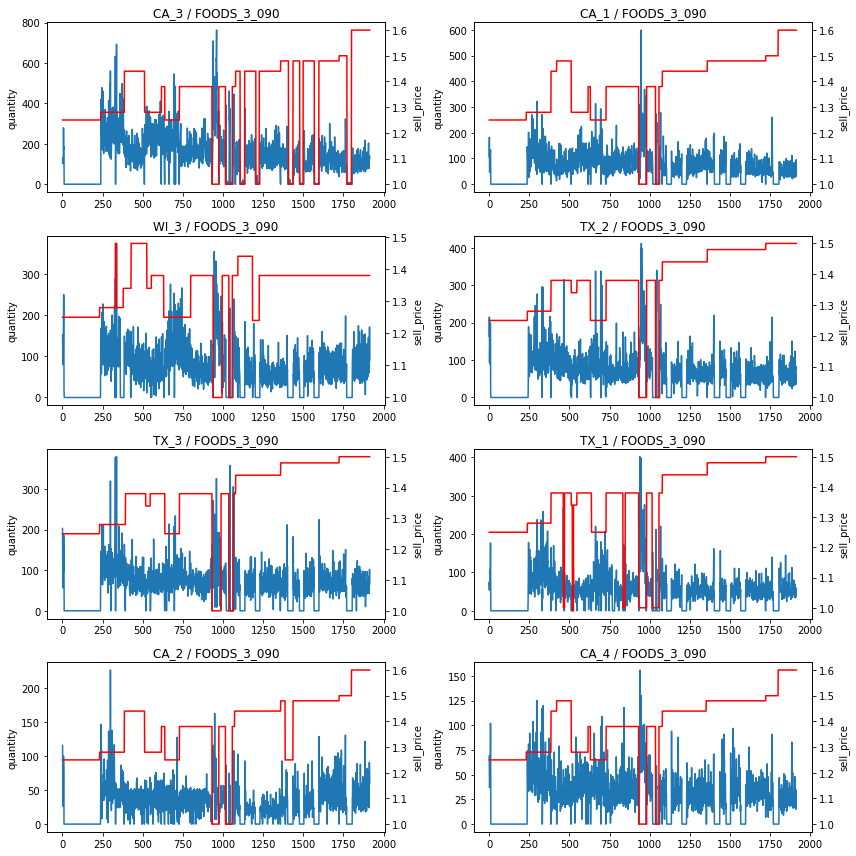

In [145]:
fig,axs = plt.subplots(figsize=(12, 12))

for i, (_, r) in enumerate(selected_products.iterrows()):
    ax = plt.subplot(4, 2, i+1)
    mask = (
        (long_sales['store_id'] == r['store_id']) &
        (long_sales['item_id'] == r['item_id'])
    )
    df = long_sales[mask]
    sns.lineplot(x=range(1, df.shape[0]+1), y='quantity', data=df, ax=ax)
    ax2 = ax.twinx()
    sns.lineplot(x=range(1, df.shape[0]+1), y='sell_price', color='red', data=df, ax=ax2)
    plt.title(f"{r['store_id']} / {r['item_id']}");
    if i == 7:
        break
    
fig.tight_layout()

can definitely see the elasticity on the plot

lets plot the products separately

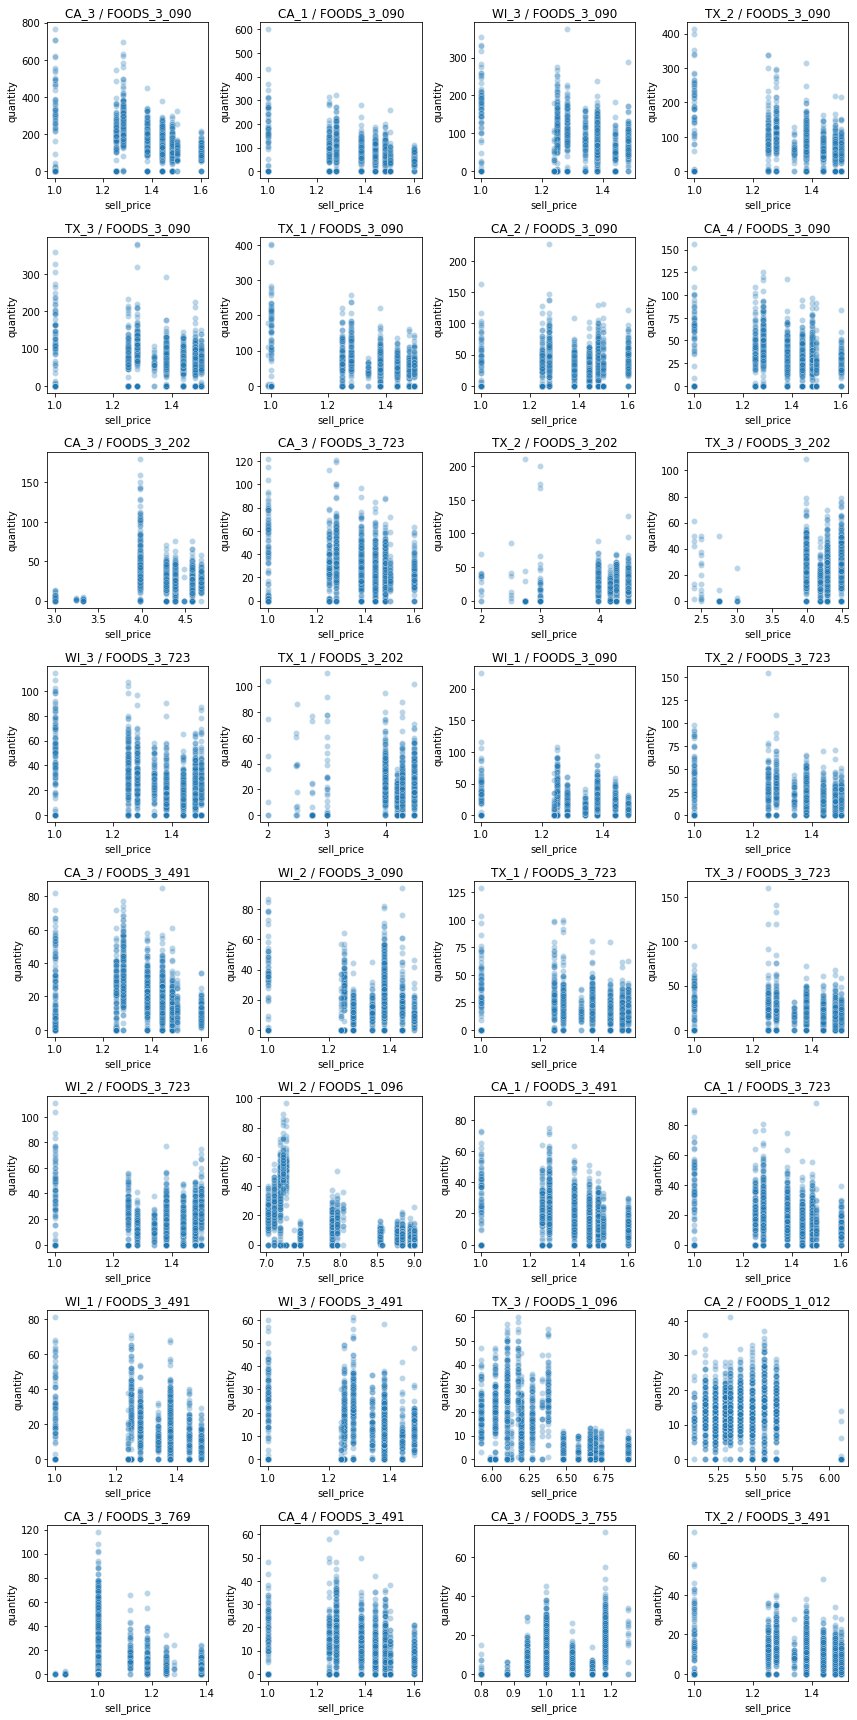

In [152]:
fig,axs = plt.subplots(figsize=(12, 24))

for i, (_, r) in enumerate(selected_products.iterrows()):
    ax = plt.subplot(8, 4, i+1)
    mask = (
        (long_sales['store_id'] == r['store_id']) &
        (long_sales['item_id'] == r['item_id'])
    )
    df = long_sales[mask]
    sns.scatterplot(x='sell_price', y='quantity', data=df, ax=ax, alpha=0.3)
    plt.title(f"{r['store_id']} / {r['item_id']}");
    if i == 31:
        break
    
fig.tight_layout()

for some products, the elasticity is not that obvious (i.e. price increases and the quantity increases

- it might be related to inflation
- it might be related to trend

### conversion rates

lets look at conversion rates instead

I define the conversion rate of a (store_id (s), item_id (p)) pair to be
$$
\frac{\textit{d_{s,p,i}}}{\sum_{j=1}^{k} d_{s,j,i}}
$$

where $d_{s, j, i}$ is the number of items sold for (store_id, product_id) pair, $k$ is the number of all products

In [195]:
sales_stores = sales.copy()

In [196]:
# sales_stores.loc[:, d_cols] = sales_stores.loc[:, d_cols].clip(0, 1).to_numpy()

In [197]:
stores_users = selected_sales.groupby('store_id')[d_cols].sum().reset_index()

In [198]:
index_columns = ['store_id']
stores_users = pd.melt(
    stores_users[index_columns+d_cols],
    id_vars = index_columns,
    var_name = 'd',
    value_name = 'user_count')

In [206]:
sales_conversion = long_sales.merge(stores_users, on=['store_id', 'd'])

In [207]:
sales_conversion['conversion'] = sales_conversion['quantity'] / sales_conversion['user_count']

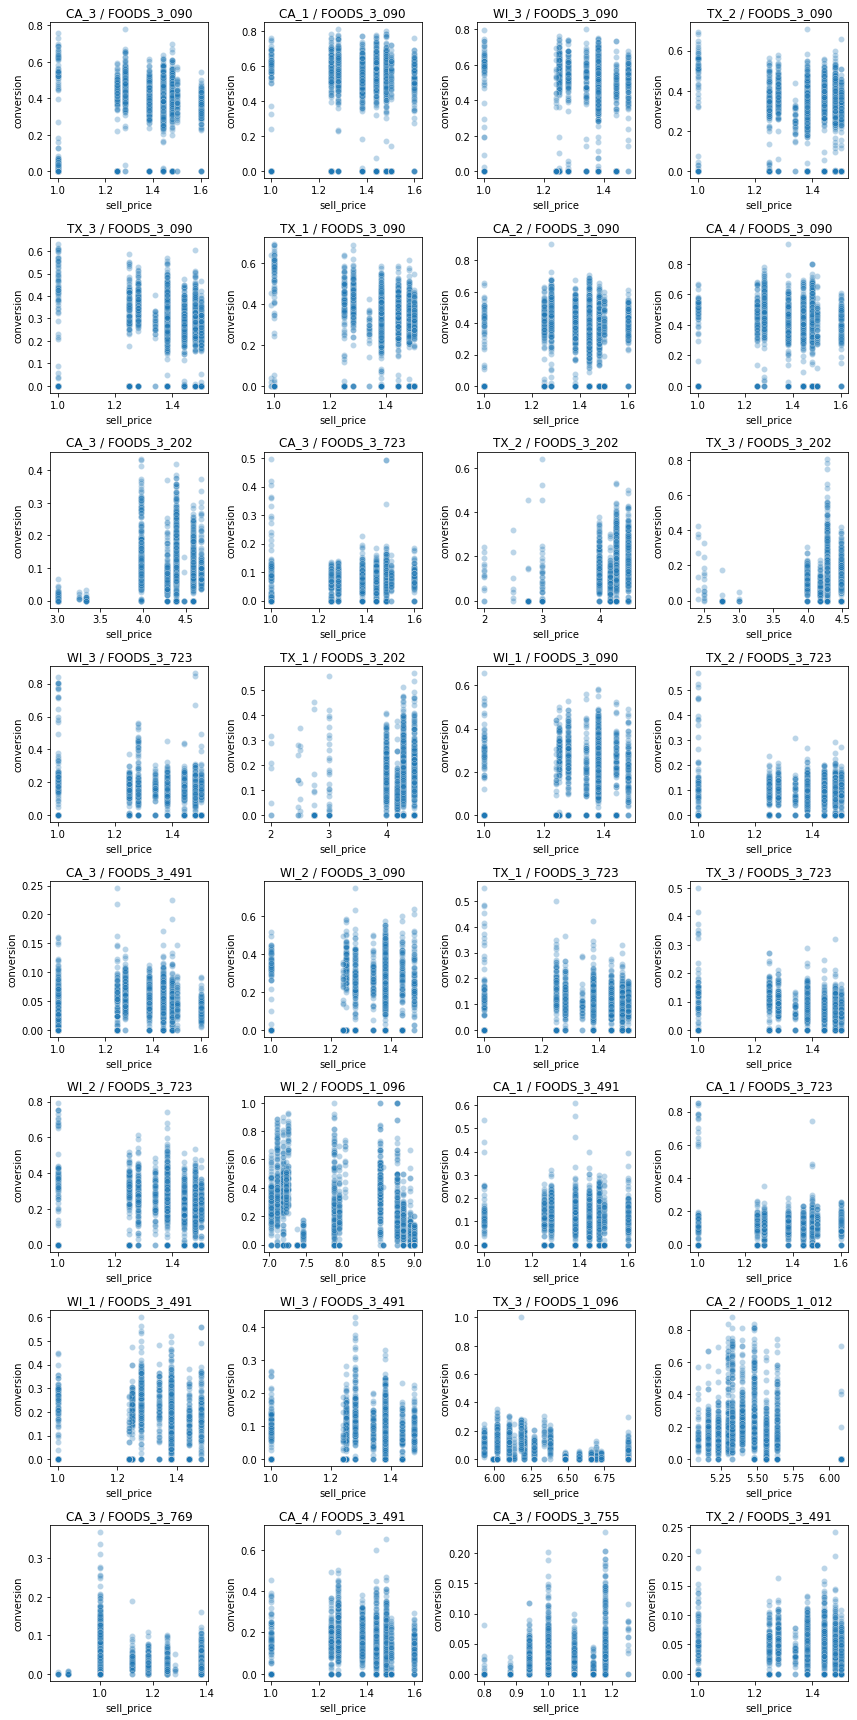

In [210]:
fig,axs = plt.subplots(figsize=(12, 24))

for i, (_, r) in enumerate(selected_products.iterrows()):
    ax = plt.subplot(8, 4, i+1)
    mask = (
        (sales_conversion['store_id'] == r['store_id']) &
        (sales_conversion['item_id'] == r['item_id'])
    )
    df = sales_conversion[mask]
    sns.scatterplot(x='sell_price', y='conversion', data=df, ax=ax, alpha=0.3)
    plt.title(f"{r['store_id']} / {r['item_id']}");
    if i == 31:
        break
    
fig.tight_layout()

detrend price additionally

## Conclusion

can definitely use the dataset for simulations